**Proyecto Final - Predicción de Obesidad a partir de Hábitos de Vida**

Trabajo realizado por:

* Diego Benavides

**Resumen**
Base de datos a Estudiar: https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition 

contiene información sobre niveles de obesidad en personas de tres países de latinoamérica: Colombia, México y Perú de acuerdo a su estado físico y sus hábitos alimenticios.

La base de datos contiene 17 atributos y 2111 registros, con la etiqueta NObesity la cual denota el nivel de obesidad, esto permite clasificar los datos en los valores de Peso insuficiente, Peso normal, Sobrepeso nivel I, Sobrepeso nivel II, Obesidad tipo I, Obesidad tipo II and obesidad tipo III. 
Del total de los datos, 77% fueron generados sintéticamente y el restante fue obtenido mediente recopilación directa con individuos a través de un portal web.

Este prouyecto consta de unaexploración no supervisada, la creación de un modelo supervisado, visualización y un análisis de los resultados.

- Modelo no supervisado: Definición de Clústers - Aplicación de PCA - TSNE.
- Modelo supervisado: tomando en cuenta los Clústers resultantes del ejercicio no supervisado
- Visualización: mediante SHAP.





**Importar librerías**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
from sklearn.cluster import KMeans,AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from joblib import dump
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder

**Cargar Base de datos y mostrar información**

Hacer un resumen de la información del dataframe y detallar el tipo de variables.

In [3]:
# Cargar datos:
df = pd.read_csv('../Datos/ObesityDataSet_raw_and_data_sinthetic.csv')

In [6]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [8]:
# Dimensión del dataframe
df.shape

(2111, 17)

In [10]:
# Información de Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [12]:
# Identificar valores nulos
display(df.isnull().sum())

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [14]:
#Valores de la etiqueta NObeyesdad
df['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

In [16]:
# Contar variables numéricas
num_variables = df.select_dtypes(include=['number']).shape[1]

# Contar variables cualitativas
non_num_variables = df.select_dtypes(exclude=['number']).shape[1]

print(f'Número de variables numéricas: {num_variables}')
print(f'Número de variables no numéricas: {non_num_variables}')

Número de variables numéricas: 8
Número de variables no numéricas: 9


**Resumen de la información de los datos**

- El dataframe consta de 17 columnas 2111 registros.
- De las 17 variables, 8 son numéricas (float64) y  son cualitativas (object).
- El dataframe no contiene valores nulos.
- Se individualizan los valores por resultadod e la etiqueta NObeyesdad para tener una idea de su distribución por sus distintos valores en el dataframe.


**Exploración de los datos y planteamiento de hipótesis**

In [18]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


**Hipótesis**

- Determinar si la frecuencia del consumo de verduras afecta significativamente todos los valores de IMC, así como la cantidad de comidas ingeridas por día, la cantidad consumida de agua y la frecuencia de actividad física. todas estas correspondientes a hábitos de las personas.

**Agrupamiento de variables cuantitativas**

In [20]:
#se retiran las variables Height y Weight
df.drop(columns=['Height', 'Weight'], inplace=True)

In [22]:
df.shape

(2111, 15)

In [24]:
variables_cuant = df.select_dtypes(['number'])
variables_cuant

,Age,FCVC,NCP,CH2O,FAF,TUE
0,21.000000,2.0,3.0,2.000000,0.000000,1.000000
1,21.000000,3.0,3.0,3.000000,3.000000,0.000000
2,23.000000,2.0,3.0,2.000000,2.000000,1.000000
3,27.000000,3.0,3.0,2.000000,2.000000,0.000000
4,22.000000,2.0,1.0,2.000000,0.000000,0.000000
...,...,...,...,...,...,...
2106,20.976842,3.0,3.0,1.728139,1.676269,0.906247
2107,21.982942,3.0,3.0,2.005130,1.341390,0.599270
2108,22.524036,3.0,3.0,2.054193,1.414209,0.646288
2109,24.361936,3.0,3.0,2.852339,1.139107,0.586035


In [34]:
le = LabelEncoder()
df['NObeyesdad'] = le.fit_transform(df['NObeyesdad'])
df["NObeyesdad"].value_counts()

NObeyesdad
2    351
4    324
3    297
5    290
6    290
1    287
0    272
Name: count, dtype: int64

In [84]:
X = df.drop('NObeyesdad', axis=1)  # Todas las columnas excepto 'NObeyesdad'
Y = df['NObeyesdad']  # Solo la columna 'NObeyesdad'


In [36]:
# Normalizar varialbes cuantitativas
scaler = StandardScaler()
variables_cuant_scaled = scaler.fit_transform(variables_cuant)

**Definir cantidad de Clusters**

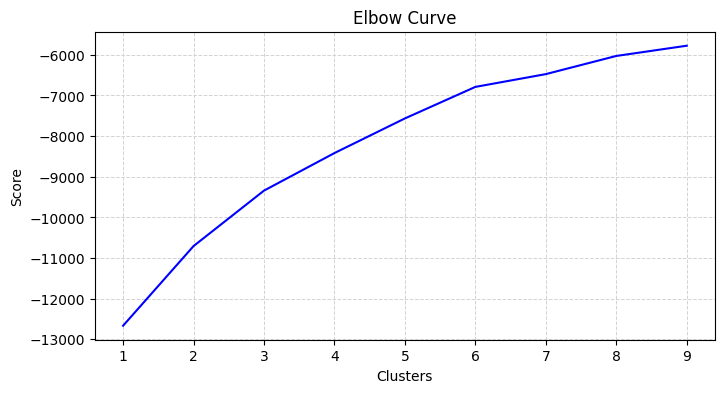

In [38]:

Nc = range(1, 10)  # Evaluar desde 1 hasta 19 clusters

# Normalizar los datos
scaler = StandardScaler()
variables_cuant_scaled = scaler.fit_transform(variables_cuant)

# Fijar una semilla para la reproducibilidad
np.random.seed(42)

# Crear una lista de modelos KMeans para cada número de clusters en Nc
kmeans = [KMeans(n_clusters=i) for i in Nc]  # Inicializar el modelo KMeans para cada valor de Nc

# Calcular la puntuación (score) para cada modelo KMeans ajustado a los datos X
score = [kmeans[i].fit(variables_cuant_scaled).score(variables_cuant_scaled) for i in range(len(kmeans))]  # Ajustar y obtener la puntuación de cada modelo

# Configuración de Gráfica
plt.figure(figsize=(8, 4))  # Establecer el tamaño de la figura para la gráfica
plt.plot(Nc, score, color='blue')
plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
plt.xticks(np.arange(1, 10, 1))
plt.xlabel('Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

plt.show()

La curva presenta un moviminto en el punto 3, por lo que se sugiere que ese es su valor óptimo

**Representación Gráfica**

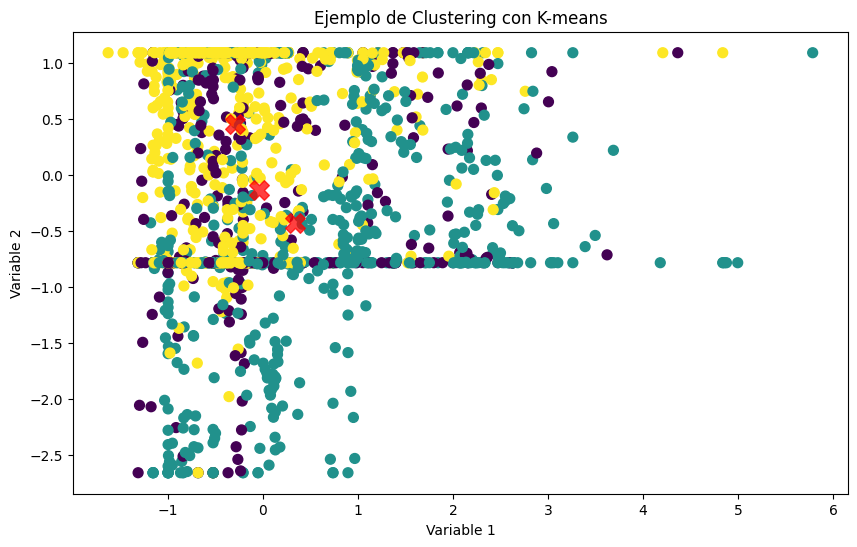

In [40]:
# Aplicación de K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(variables_cuant_scaled)
y_kmeans = kmeans.predict(variables_cuant_scaled)

# Centros de clusters
centers = kmeans.cluster_centers_

# Representación gráfica
plt.figure(figsize=(10, 6))
plt.scatter(variables_cuant_scaled[:, 0], variables_cuant_scaled[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('Ejemplo de Clustering con K-means')
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.show()

**Aplicacón de PCA**

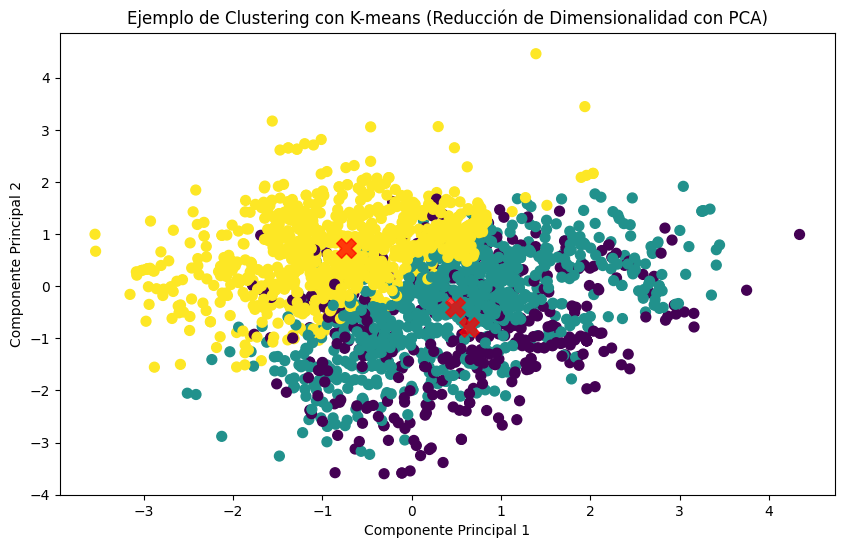

In [42]:
# Variables cuantitativas
variables_cuantitativas = df.select_dtypes(include=['number'])

# Normalizar las variables cuantitativas
scaler = StandardScaler()
variables_cuant_scaled = scaler.fit_transform(variables_cuant)

# Aplicación K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(variables_cuant_scaled)
y_kmeans = kmeans.predict(variables_cuant_scaled)

# Reducción de dimensionalidad PCA
pca = PCA(n_components=2)
variables_pca = pca.fit_transform(variables_cuant_scaled)
centers_pca = pca.transform(kmeans.cluster_centers_)

# Visualización de los clusters
plt.figure(figsize=(10, 6))
plt.scatter(variables_pca[:, 0], variables_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('Ejemplo de Clustering con K-means (Reducción de Dimensionalidad con PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

**Análsis de gráfica**

- Aplicando PCA se puede ver cómo el cluster verde se dispersa en el mismo espectro del cluster violeta, dando a pensar que que la división de clusters podría ser de dos y no de tres como se evidenció en el gráfico de codo

**Se procede a repetir gráfica esta vez con 2 clusters**

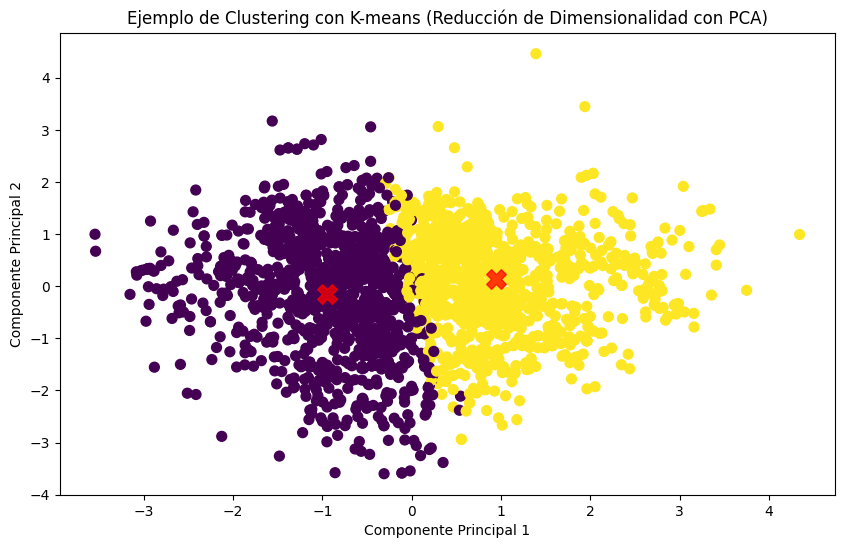

In [44]:
# Variables cuantitativas
variables_cuantitativas = df.select_dtypes(include=['number'])

# Normalizar las variables cuantitativas
scaler = StandardScaler()
variables_cuant_scaled = scaler.fit_transform(variables_cuant)

# Aplicación K-means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(variables_cuant_scaled)
y_kmeans = kmeans.predict(variables_cuant_scaled)

# Reducción de dimensionalidad PCA
pca = PCA(n_components=2)
variables_pca = pca.fit_transform(variables_cuant_scaled)
centers_pca = pca.transform(kmeans.cluster_centers_)

# Visualización de los clusters
plt.figure(figsize=(10, 6))
plt.scatter(variables_pca[:, 0], variables_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('Ejemplo de Clustering con K-means (Reducción de Dimensionalidad con PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

**Análisis**

-Se evidencia una mayor diferenciación repartiendo en dos clusters.

**Aplicación de TSNE**

In [46]:
# Datos del dataset de obesidad
X1 = df.drop(columns=['NObeyesdad'])  # Datos de las características, excluyendo la etiqueta
y1 = df['NObeyesdad']  # Etiquetas del dataset (NObeyesdad)

# Convertir las variables categóricas en variables dummy (One-Hot Encoding)
X_encoded = pd.get_dummies(X1)

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Mostramos las dimensiones de los datos
print(f"Dimensiones de los datos de las características: {X1.shape}")
print(f"Dimensiones de las etiquetas: {y1.shape}")

Dimensiones de los datos de las características: (2111, 14)
Dimensiones de las etiquetas: (2111,)


In [48]:
# Configuración de t-SNE con 2 componentes
tsne = TSNE(n_components=2, random_state=0)

# Reducción de la dimensionalidad
X_2d = tsne.fit_transform(X_scaled)

In [49]:
# Mostrar las dimensiones resultantes
print(f"Dimensiones después de t-SNE: {X_2d.shape}")

Dimensiones después de t-SNE: (2111, 2)


**Gráfica**

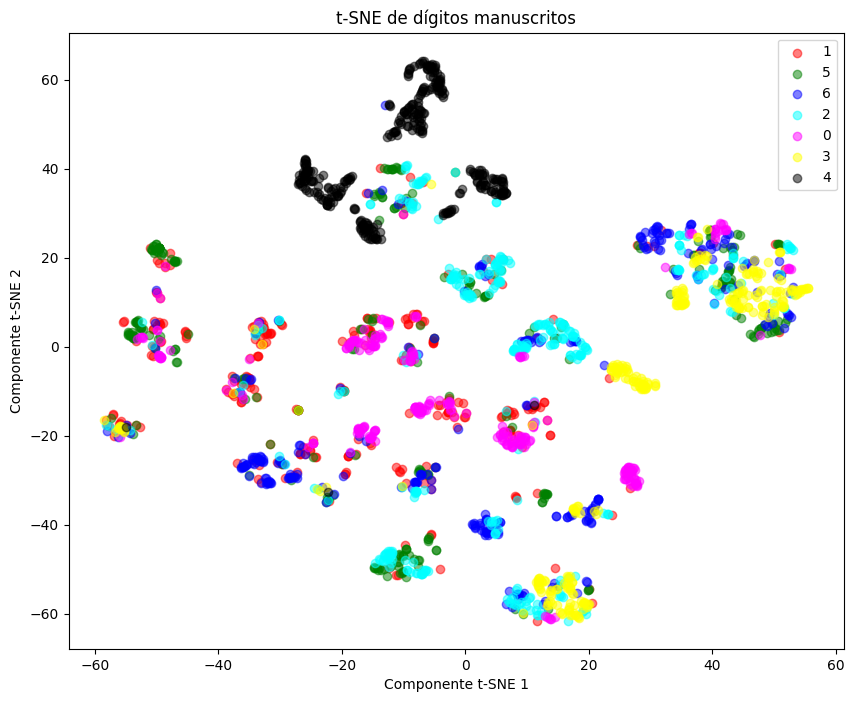

In [50]:
# Configuramos el tamaño de la figura
plt.figure(figsize=(10, 8))

# Colores para cada clase en el dataset de obesidad
unique_classes = y1.unique()  # Obtener las categorías únicas de NObeyesdad
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'darkgrey', 'lime']

# Dibujamos los puntos para cada clase
for i, category in enumerate(unique_classes):
    plt.scatter(X_2d[y1 == category, 0], X_2d[y1 == category, 1], 
                c=colors[i % len(colors)], label=category, alpha=0.5)

# Añadimos la leyenda y los títulos
plt.legend()
plt.title('t-SNE de dígitos manuscritos')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')

# Mostramos el gráfico
plt.show()

**Interpretación**
- Se logra obtener una diferenciación en los habitos para el el grupó de obesidad tipo III, ya que sus habitos están más aislados que para el resto de grupos.
- Se evidencia que es difícil determinar (aislar) los hábitos para sobrepeso nivel I y II, así como los del grupo de peso insuficiente, lo que lleva a pensar que pueden ser otro tipo de varialbes las necesarias para validar.
- después del grupo de obesidad tipo III, se encuentran un poco más aislados los hábitos del grupo de obesidad tipo I, aunque de forma leve.
- para finalizar, sí se evidencia que los hábitos de los individuos afectan considerablemente el IMC, pero se muestra un aislamiento de hábitos mucho mayor para el tipo III de obesidad, lo que da a entender que los hábitos del resto de grupos, excluyendo parcialmente al tipo I y II de obesidad (que muestran un leve aislamiento de hábitos) cuentan con comportamientos muy similares.



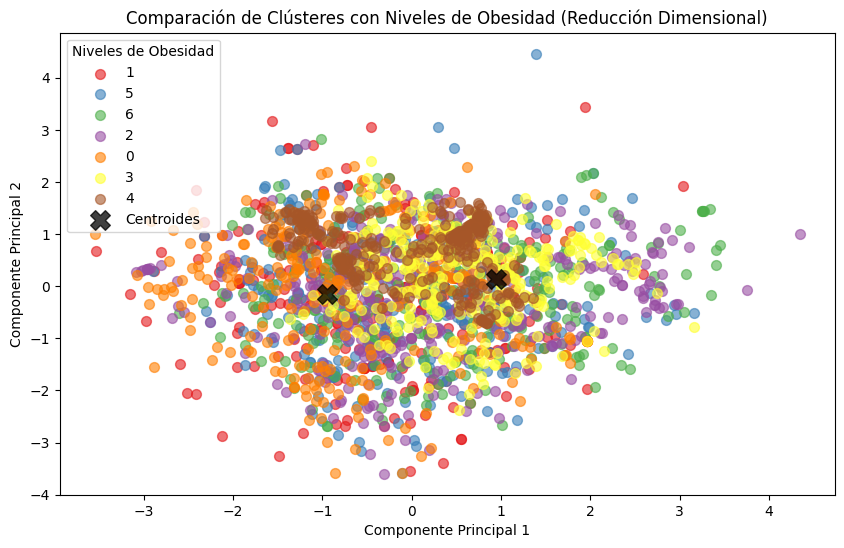

In [54]:
# Mapeo de los niveles de obesidad a colores
obesity_levels = df['NObeyesdad'].unique()
color_map = {level: color for level, color in zip(obesity_levels, plt.cm.Set1.colors)}

# Visualización de los clústeres con niveles de obesidad
plt.figure(figsize=(10, 6))
for level in obesity_levels:
    indices = df['NObeyesdad'] == level
    plt.scatter(variables_pca[indices, 0], variables_pca[indices, 1], 
                s=50, label=level, alpha=0.6, color=color_map[level])

# Centros de los clústeres
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=200, alpha=0.75, marker='X', label='Centroides')

plt.title('Comparación de Clústeres con Niveles de Obesidad (Reducción Dimensional)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Niveles de Obesidad')
plt.show()

**Análisis del gráfico**

Se puede ver una concentración de los puntos correspondientes a obesidad tipo III en la parte superior y central de la gráfica, así como una leve concentración en la parte extrema derecha de obesidad tipo I.
Los demás niveles de obesidad se encuentran dispersos por toda la gráfica.

**Selección de Modelo K-means**

In [56]:
#Agregar las etiquetas de los clusters al DataFrame original 
#variables_cuantitativas['Cluster'] = y_kmeans
#variables_cuantitativas.head()
variables_cuantitativas = variables_cuant.copy()
variables_cuantitativas['Cluster'] = y_kmeans
variables_cuantitativas.head()

,Age,FCVC,NCP,CH2O,FAF,TUE,Cluster
0,21.0,2.0,3.0,2.0,0.0,1.0,0
1,21.0,3.0,3.0,3.0,3.0,0.0,0
2,23.0,2.0,3.0,2.0,2.0,1.0,0
3,27.0,3.0,3.0,2.0,2.0,0.0,1
4,22.0,2.0,1.0,2.0,0.0,0.0,1


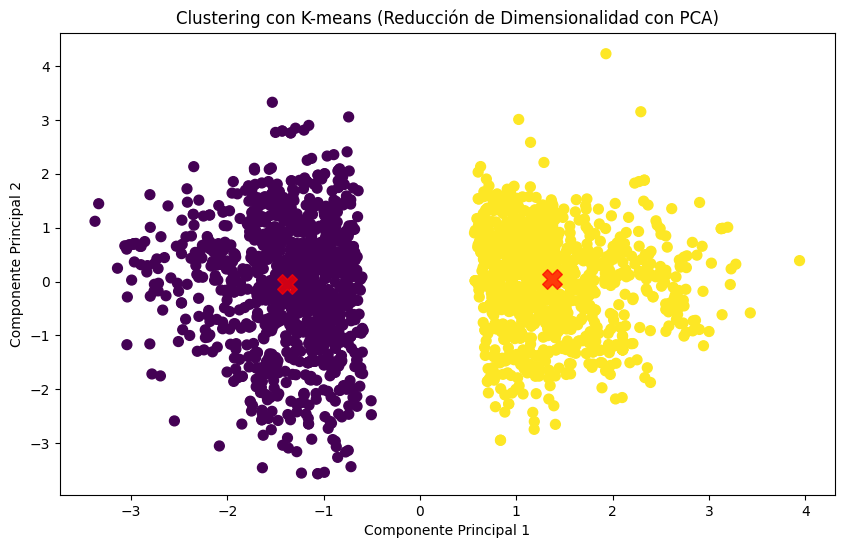

In [138]:
# Normalizar las variables cuantitativas
scaler = StandardScaler()
variables_cuantitativas_scaled = scaler.fit_transform(variables_cuantitativas)

# Aplicación de K-means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(variables_cuantitativas_scaled)
y_kmeans = kmeans.predict(variables_cuantitativas_scaled)

# Reducción de dimensionalidad usando PCA
pca = PCA(n_components=2)
variables_pca = pca.fit_transform(variables_cuantitativas_scaled)
centers_pca = pca.transform(kmeans.cluster_centers_)

# Visualización de los clusters
plt.figure(figsize=(10, 6))
plt.scatter(variables_pca[:, 0], variables_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('Clustering con K-means (Reducción de Dimensionalidad con PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

**Analális de nuevo modelo**

Se evidencia que al añadir como caracteristica Clúster se asentúa los clústers, definiéndolos de una forma mas plara y precisa.

**Visualización**

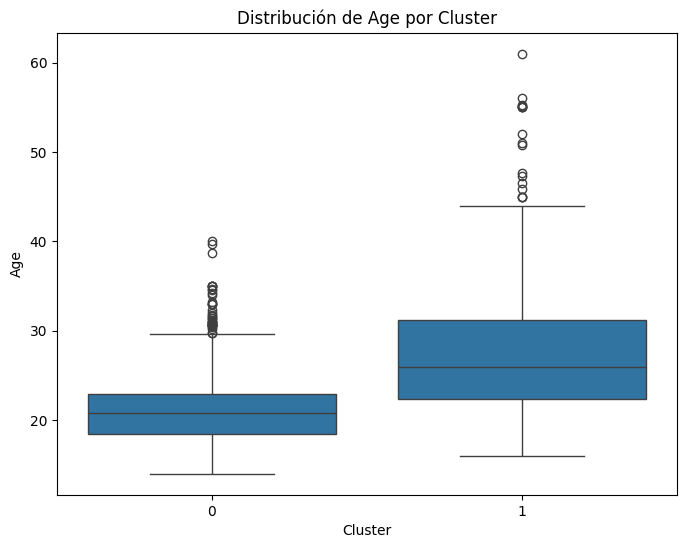

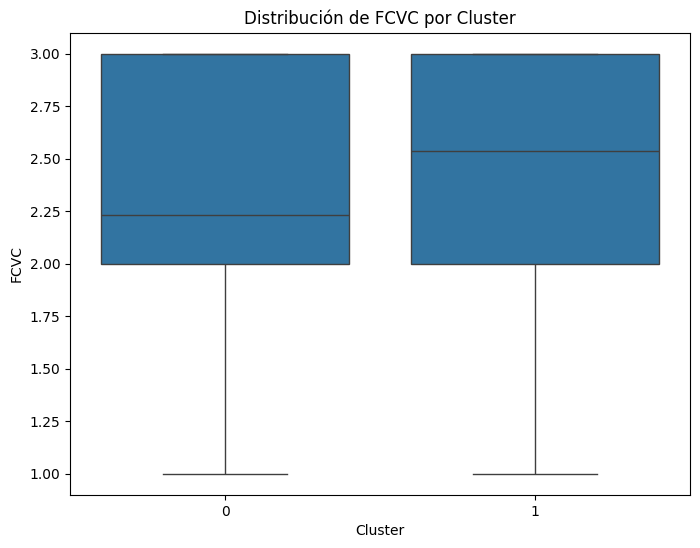

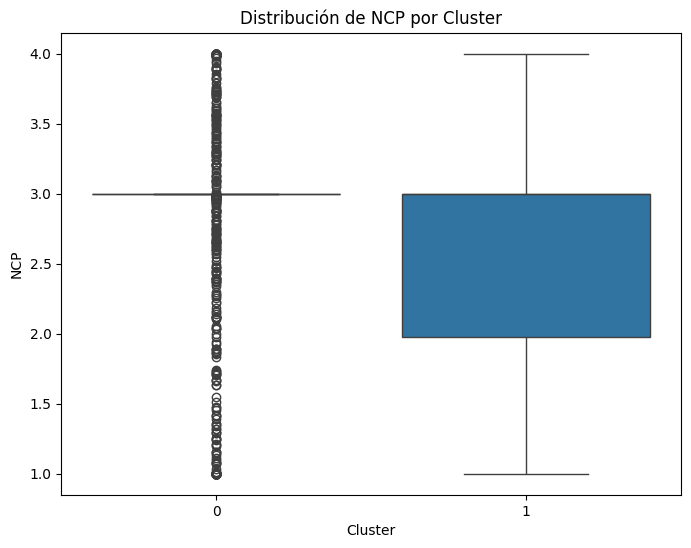

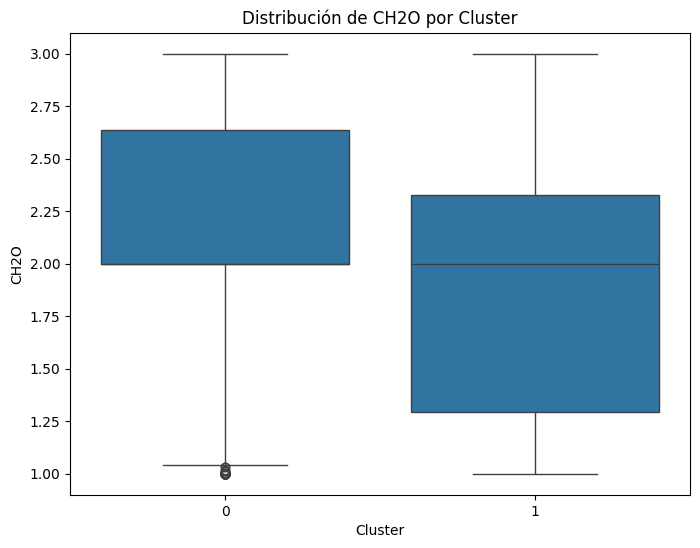

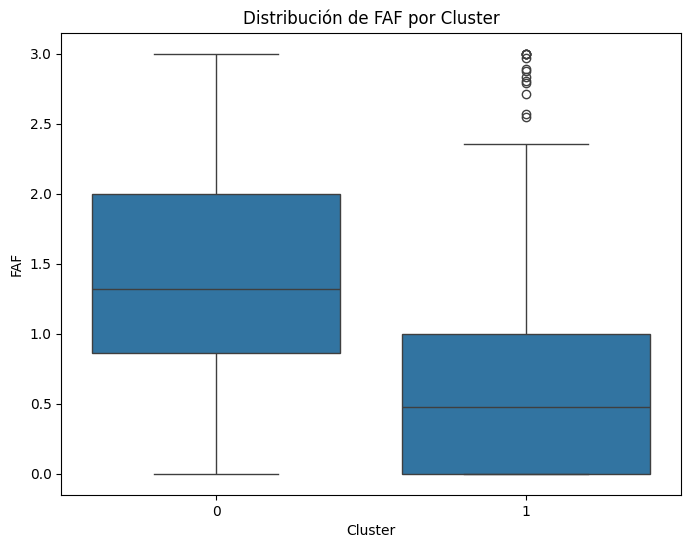

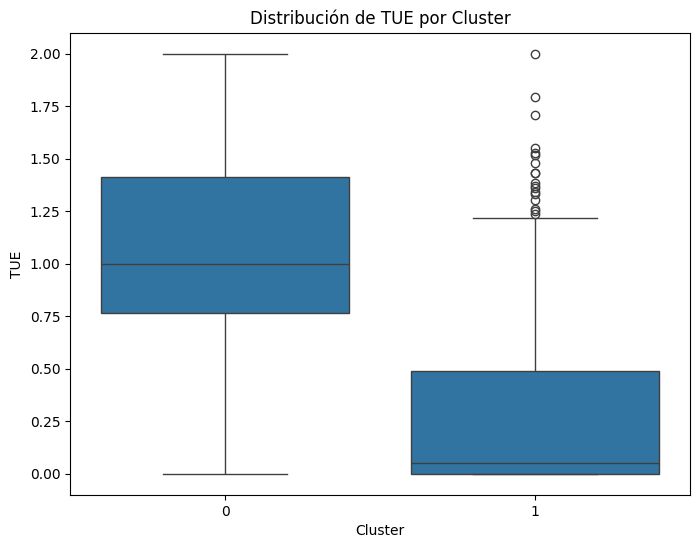

In [67]:
#Distribución de cada variable dentro de cada cluster 

for column in ['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Cluster', y=column, data=variables_cuantitativas) 
    plt.title(f'Distribución de {column} por Cluster')
    plt.show()

In [69]:
# Calcular la media de cada variable cuantitativa para cada cluster
cluster_means = variables_cuantitativas.groupby('Cluster')[['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']].mean()
                           
#Mostrar las medias
print(cluster_means)

               Age      FCVC       NCP      CH2O       FAF       TUE
Cluster                                                             
0        21.118450  2.365158  2.854403  2.139016  1.362389  1.047810
1        27.473634  2.472369  2.518603  1.878365  0.661857  0.271965


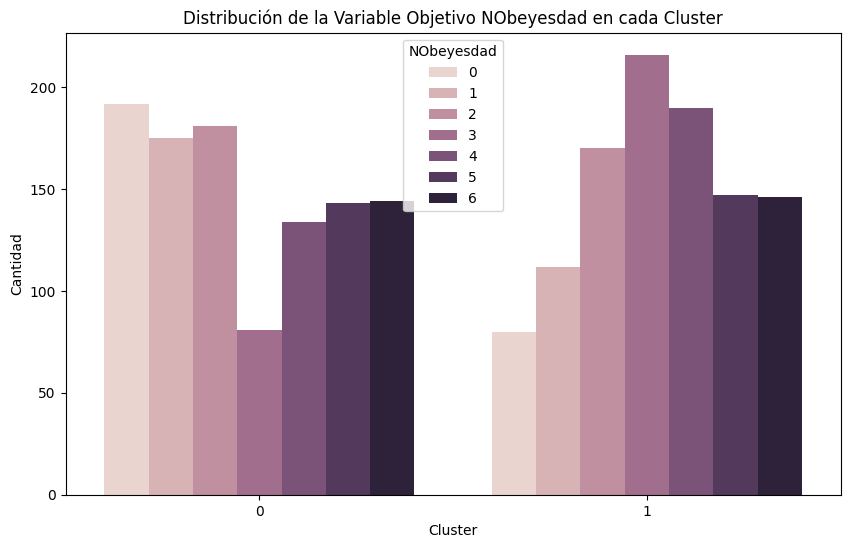

Tabla de Contingencia entre Cluster y NObeyesdad:
NObeyesdad    0    1    2    3    4    5    6
Cluster                                      
0           192  175  181   81  134  143  144
1            80  112  170  216  190  147  146


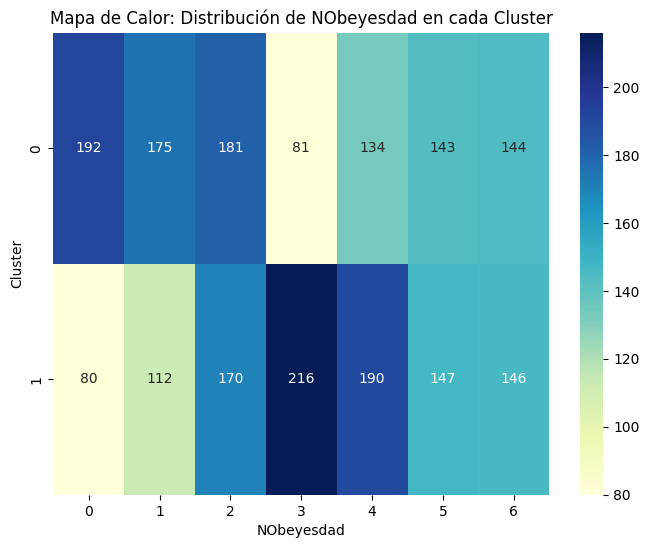

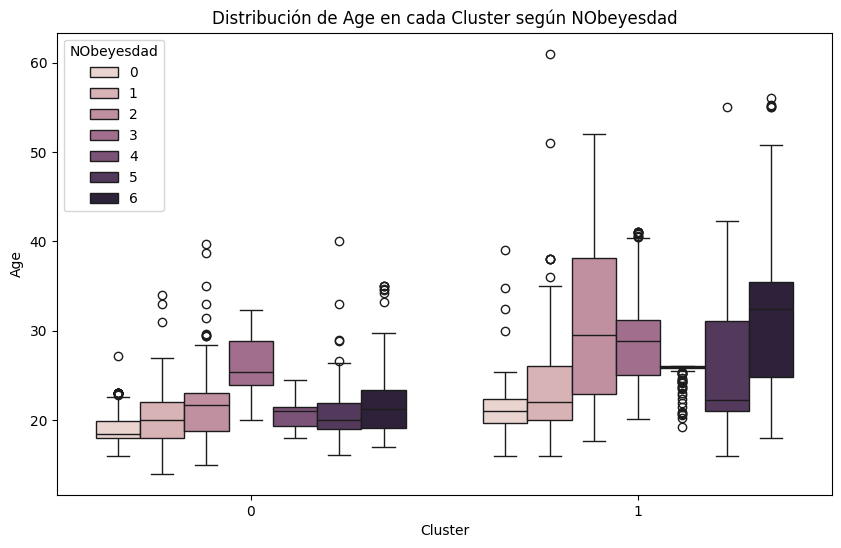

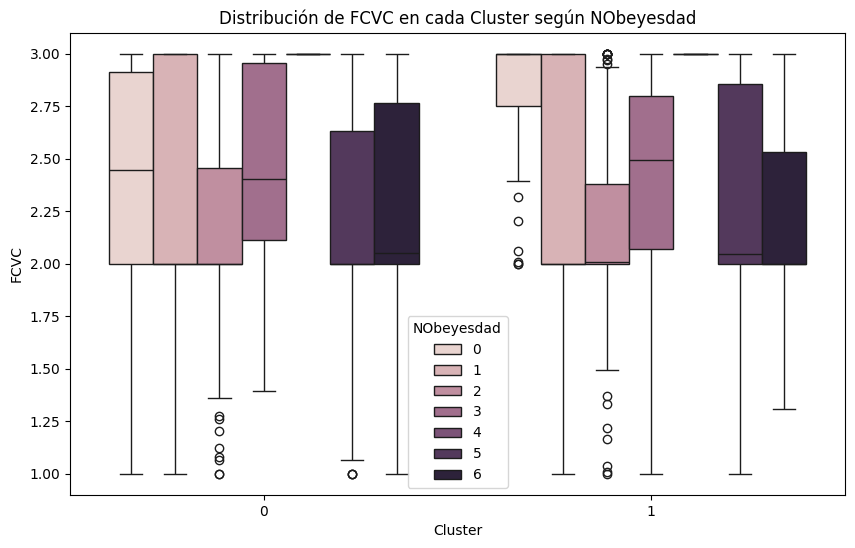

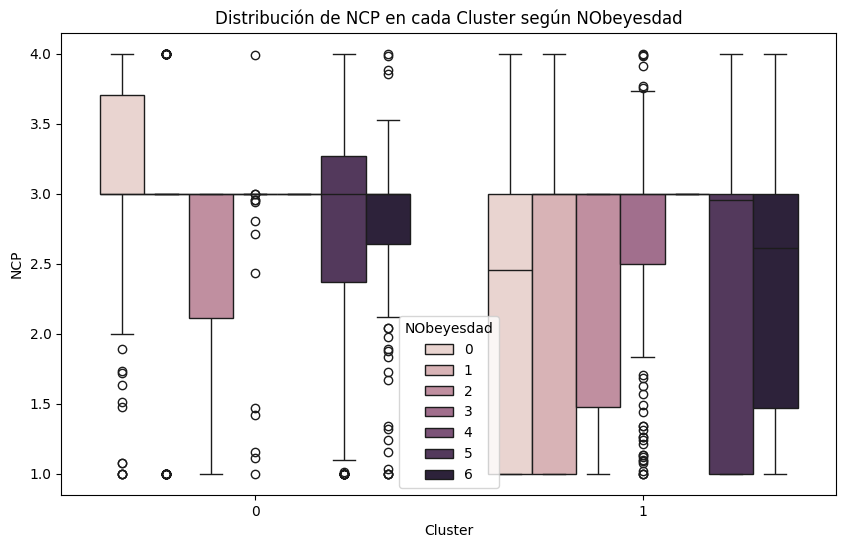

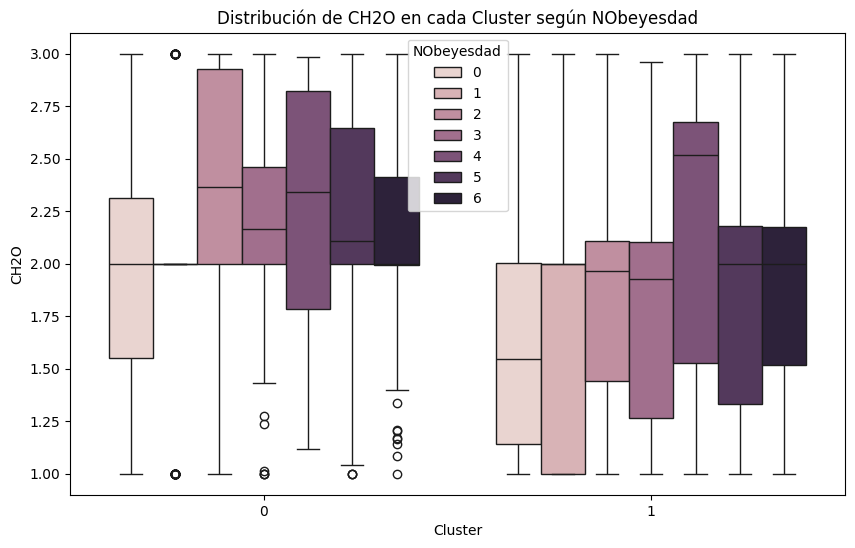

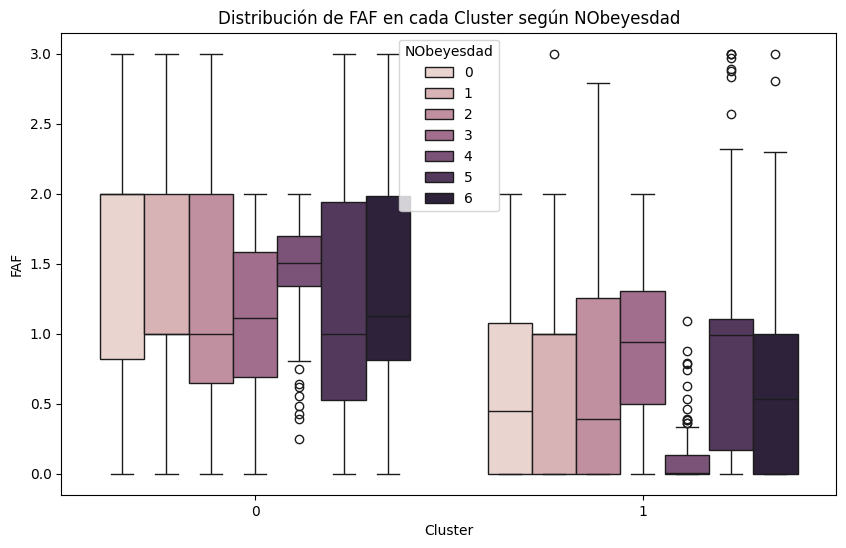

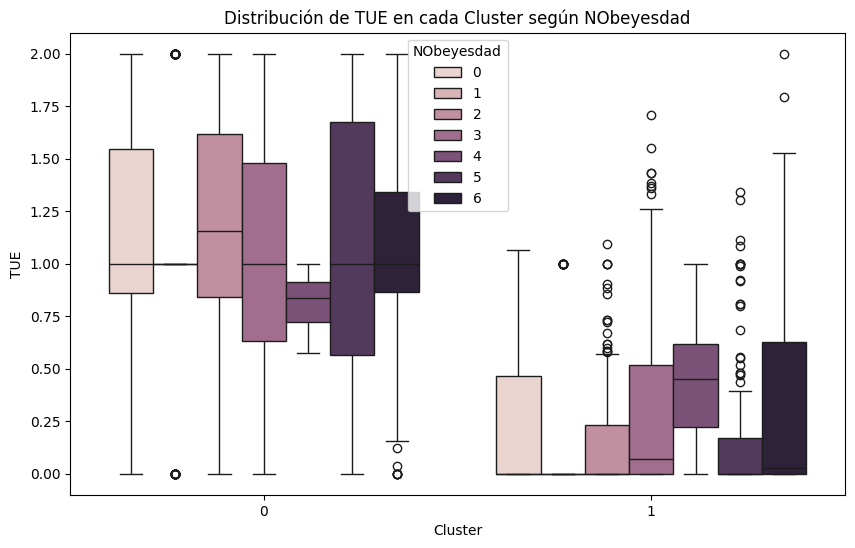

In [73]:
# df_y contiene solo la variable objetivo 'NObeyesdad'
# df contiene las variables cuantitativas y la columna 'Cluster'

df_variable_objetivo = df['NObeyesdad']
df_combined = pd.concat([variables_cuantitativas, df_variable_objetivo], axis=1)
 
plt.figure(figsize=(10, 6))
sns.countplot(data=df_combined, x="Cluster", hue="NObeyesdad")
plt.title("Distribución de la Variable Objetivo NObeyesdad en cada Cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad")
plt.legend(title="NObeyesdad")
plt.show()
 
# Crear una tabla de contingencia para contar la frecuencia de cada combinación de cluster y objetivo
contingency_table = pd.crosstab(df_combined["Cluster"], df_combined["NObeyesdad"])
 
print("Tabla de Contingencia entre Cluster y NObeyesdad:")
print(contingency_table)
 
# Visualizar la tabla de contingencia con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Mapa de Calor: Distribución de NObeyesdad en cada Cluster")
plt.xlabel("NObeyesdad")
plt.ylabel("Cluster")
plt.show()
 
# Visualización en la distribución de las variables numéricas en cada Cluster y por NObeyesdad
for column in ["Age", "FCVC", "NCP", "CH2O", "FAF", "TUE"]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_combined, x="Cluster", y=column, hue="NObeyesdad")
    plt.title(f"Distribución de {column} en cada Cluster según NObeyesdad")
    plt.xlabel("Cluster")
    plt.ylabel(column)
    plt.legend(title="NObeyesdad")
    plt.show()

**Conclusiones**
Segmentando mediante el método de Clústers se identifican conductas relacionadas entre los individuos que tienen distintos niveles de obesidad:

- Obesity_Type_I         - 
Obesity_Type_III      4- 
Obesity_Type_II      9- 7
Overweight_Level_I  2- 90
Overweight_Level_II - 290
Normal_Weight      -  287
Insufficient_
- 
De esta forma se pueden buscar relaciones de conductas buscando agrupar los individuos, que en este caso, de acuerdo al modelo optimizado fueron 2 clústers.
La optimización del modelo permitió individualizar mucho más los Clusters definiendo el comportamiento de ambos grupos.

Por motivos del versionado, no fue posible realizar análisis SHAP, pero se aplicaron técnicas como T-SNE, el cual permitió identificar de una mejor forma dichas caracteristicas las cuales ajustaron el modelo.

**Reflexión del ejercicio**
La segmentación realizada para el estudio de este dataset ayuda a la identificación de patrnes conjuntos que tienen en sus hábitos diferentes niveles de obesidad, identificar esto permite identificar y prevenir subir el nivel de obesidad.

**Bibliografía**
Zainea Maya, C. I. (2022). Seminario-de-programacion (Version 1.0.0) [Computer software].
https://bit.ly/3BjfLLN.


       272